In [ ]:
# 1) Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [ ]:
# 2) Load the balanced dataset directly
file_path = "/content/balanced_data.csv"  # change if needed
df = pd.read_csv(file_path)


# 3) Drop obvious ID-like columns if present
for c in ["trans_num","cc_num","full_name","first","last","street","Unnamed: 0"]:
    if c in df.columns: df.drop(columns=c, inplace=True)

# 4) Build minimal time feature (is_night) from unix_time only
if "unix_time" in df.columns:
    t = pd.to_datetime(df["unix_time"], unit="s", errors="coerce")
    df["is_night"] = t.dt.hour.isin([22,23,0,1,2,3,4,5]).astype(int)
else:
    df["is_night"] = 0  # fallback



# 6) Build distance_km from (lat,long) → (merch_lat, merch_long); else 0.0
def haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 6371.0 * (2.0 * np.arcsin(np.sqrt(a)))

have_coords = all(c in df.columns for c in ["lat","long","merch_lat","merch_long"])
if have_coords:
    df["distance_km"] = haversine_km(df["lat"], df["long"], df["merch_lat"], df["merch_long"])
else:
    df["distance_km"] = 0.0  # fallback

# 7) Train/test split (80/20, stratified)
features_needed = ["merchant","city","city_pop","log_amt","is_night","distance_km","is_fraud"]
missing = [c for c in features_needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

X_full = df[["merchant","city","city_pop","log_amt","is_night","distance_km"]].copy()
y = df["is_fraud"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.20, stratify=y, random_state=42
)

print("# Train/Test sizes:", len(X_train), len(X_test))
print("# Train classes:", y_train.value_counts().sort_index().to_dict())
print("# Test classes :", y_test.value_counts().sort_index().to_dict())

# 8) Train-only target encoding for merchant and city (avoid label-distance issues)
tmp = X_train.assign(is_fraud=y_train.values)
m_map = tmp.groupby("merchant")["is_fraud"].mean()
c_map = tmp.groupby("city")["is_fraud"].mean()

def apply_te(dfX):
    out = dfX.copy()
    out["merchant_te"] = out["merchant"].map(m_map).fillna(y_train.mean())
    out["city_te"]     = out["city"].map(c_map).fillna(y_train.mean())
    return out

X_train_te = apply_te(X_train)
X_test_te  = apply_te(X_test)

# 9) Final TOP-6 features (recall-oriented, diverse)
top6 = ["merchant_te","city_te","city_pop","log_amt","is_night","distance_km"]
X_train_final = X_train_te[top6].copy()
X_test_final  = X_test_te[top6].copy()

print("# Using features:", top6)

# 10) Scale features (fit scaler on TRAIN only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_final)
X_test_s  = scaler.transform(X_test_final)

# 11) KNN over k values (distance weights + Manhattan), choose by recall → precision → accuracy
k_values = [3,5,7,9,11]
print("\n# k values tested:", k_values)

best_k = None
best_key = None
best_cm = None

print("\n# Results with TE + diverse TOP-6 (recall-focused):")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance", p=1)  # Manhattan + distance weights
    knn.fit(X_train_s, y_train)
    y_pred = knn.predict(X_test_s)

    acc = accuracy_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"k={k}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}")
    key = (round(rec,5), round(prec,5), round(acc,5))  # recall → precision → accuracy
    if (best_key is None) or (key > best_key):
        best_key, best_k, best_cm = key, k, cm

# 12) Print best selection
print(f"\nBest k (recall-first): {best_k}")
print(f"Accuracy={best_key[2]:.3f}, Precision={best_key[1]:.3f}, Recall={best_key[0]:.3f}")
print("Confusion Matrix (best):")
print(best_cm)

FileNotFoundError: [Errno 2] No such file or directory: '/content/balanced_data.csv'

# Results (by k):
k=3: acc=0.945, prec=0.879, rec=0.862, f1=0.871
k=5: acc=0.947, prec=0.885, rec=0.865, f1=0.875
k=7: acc=0.949, prec=0.888, rec=0.872, f1=0.880
k=9: acc=0.947, prec=0.884, rec=0.867, f1=0.875
k=11: acc=0.947, prec=0.882, rec=0.867, f1=0.874


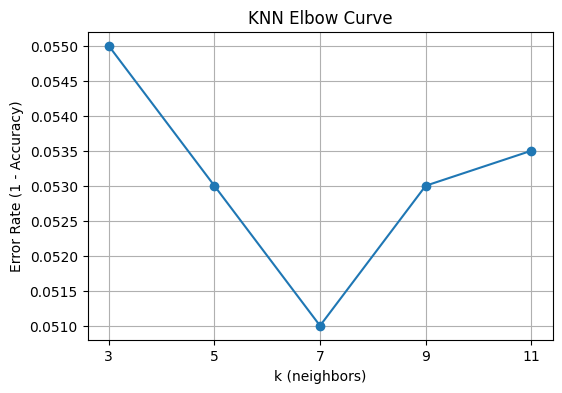

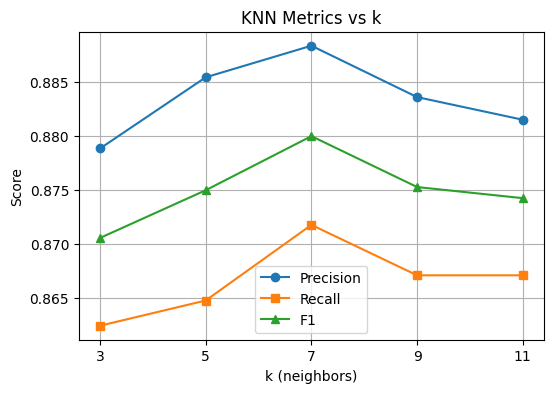

In [ ]:
# KNN metrics vs k (and elbow) – using your current scaled train/test and recall-first tie-break

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# If you already have X_train_s / X_test_s, comment out the next 3 lines
# scaler = StandardScaler()
# X_train_s = scaler.fit_transform(X_train_final)
# X_test_s  = scaler.transform(X_test_final)

k_values = [3, 5, 7, 9, 11]   # add 1 if you also want to compare k=1
weights = "distance"
p = 1  # Manhattan

knn_k_metrics = []  # (k, acc, prec, rec, f1)

print("# Results (by k):")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights=weights, p=p)
    knn.fit(X_train_s, y_train)
    y_pred = knn.predict(X_test_s)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    knn_k_metrics.append((k, acc, prec, rec, f1))
    print(f"k={k}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")

# Elbow: error rate vs k
ks   = [r[0] for r in knn_k_metrics]
errs = [1 - r[1] for r in knn_k_metrics]
plt.figure(figsize=(6,4))
plt.plot(ks, errs, marker='o')
plt.xlabel("k (neighbors)")
plt.ylabel("Error Rate (1 - Accuracy)")
plt.title("KNN Elbow Curve")
plt.xticks(ks)
plt.grid(True)
plt.show()

# Precision / Recall / F1 vs k
precs = [r[2] for r in knn_k_metrics]
recs  = [r[3] for r in knn_k_metrics]
f1s   = [r[4] for r in knn_k_metrics]
plt.figure(figsize=(6,4))
plt.plot(ks, precs, marker='o', label="Precision")
plt.plot(ks, recs,  marker='s', label="Recall")
plt.plot(ks, f1s,   marker='^', label="F1")
plt.xlabel("k (neighbors)")
plt.ylabel("Score")
plt.title("KNN Metrics vs k")
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()


Using k=7 for ROC
AUC = 0.963


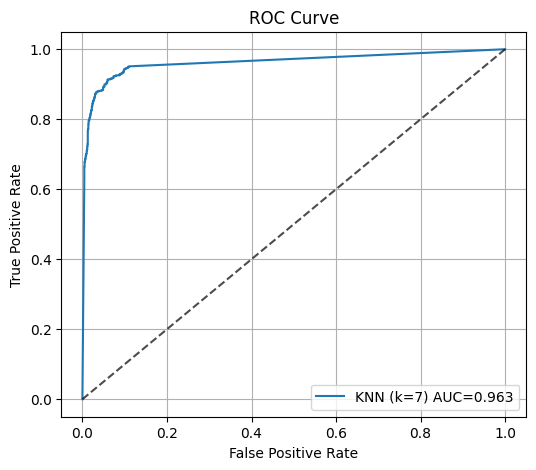

In [ ]:
# ROC curve (uses the k with highest recall, then precision, then accuracy)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# choose k by recall -> precision -> accuracy
best_k = max(knn_k_metrics, key=lambda r: (r[3], r[2], r[1]))[0]
print(f"Using k={best_k} for ROC")

knn = KNeighborsClassifier(n_neighbors=best_k, weights="distance", p=1)
knn.fit(X_train_s, y_train)
y_prob = knn.predict_proba(X_test_s)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC = {auc_score:.3f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"KNN (k={best_k}) AUC={auc_score:.3f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
